In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import cmath
import sympy as sym
from sympy import exp, symbols, lambdify
import math
from pytictoc import TicToc
import numba
from numba import jit
import time

In [2]:
a=0.04
b=5.
c=140.
ga=12.
gg=12.
Delta=1.
Eta=18.
Iext=0.
Ea=0.
Eg=-80.
tauSa=5.
tauSg=5.
Sja=0.8
Sjg=1.2
ud=12.
alpha=0.013
beta=.4
k=10e4 #10e4,
Vmax=1300.
Km=50.
Bd=0.2
Ad=1.
tau_Dp=500.
params=np.array([a, b, c, ga, gg, Eta, Delta, Iext, Ea, Eg, Sja, Sjg, tauSa, tauSg, alpha, beta, ud, k, Vmax, Km, Bd, Ad, tau_Dp])

In [3]:
regions_labels = ["L.BSTS", "L.CACG", "L.CMFG", "L.CU", "L.EC", "L.FG", "L.IPG", "L.ITG", "L.ICG","L.LOG", "L.LOFG", "L.LG", "L.MOFG", "L.MTG", "L.PHIG", "L.PaCG", "L.POP", "L.POR","L.PTR", "L.PCAL", "L.PoCG", "L.PCG", "L.PrCG", "L.PCU", "L.RACG", "L.RMFG", "L.SFG",
    "L.SPG", "L.STG", "L.SMG", "L.FP", "L.TP", "L.TTG", "L.IN", "L.CER", "L.TH", "L.CA","L.PU", "L.HI", "L.AC", "lh-GPe", "lh-GPi", "lh-STN", "rh-GPe","rh-GPi", "rh-STN", "R.TH", "R.CA", "R.PU", "R.HI",  "R.AC", "R.BSTS",
    "R.CACG", "R.CMFG", "R.CU", "R.EC", "R.FG", "R.IPG", "R.ITG", "R.ICG", "R.LOG","R.LOFG", "R.LG", "R.MOFG", "R.MTG", "R.PHIG", "R.PaCG", "R.POP", "R.POR", "R.PTR","R.PCAL", "R.PoCG", "R.PCG", "R.PrCG", "R.PCU", "R.RACG", "R.RMFG", "R.SFG", "R.SPG",
    "R.STG", "R.SMG", "R.FP", "R.TP", "R.TTG", "R.IN", "R.CER","SubstantiaNigraLH","SubstantiaNigraRH"]
idx_conn = [36, 37, 42, 45, 47, 48]


In [4]:
conn_dopamine=np.load("conn_dopamine.npy")
conn_excitator=np.load("conn_excitator.npy")
conn_inhibitor=np.load("conn_inhibitor.npy")

In [5]:
from numba import njit


@njit
def aQIFdopa(y,t,params,coupling_inhibitor,coupling_excitator,coupling_dopamine):
    r = y[0*n_nodes : 1*n_nodes]
    V = y[1*n_nodes : 2*n_nodes]
    u = y[2*n_nodes : 3*n_nodes]
    Sa = y[3*n_nodes : 4*n_nodes]
    Sg = y[4*n_nodes : 5*n_nodes]
    Dp = y[5*n_nodes : 6*n_nodes]
    #y = np.concatenate((r, V, u, Sa, Sg, Dp))
    a, b, c, ga, gg, Eta, Delta, Iext, Ea, Eg, Sja, Sjg, tauSa, tauSg, alpha, beta, ud, k, Vmax, Km, Bd, Ad, tau_Dp=params
    c_inh = coupling_inhibitor
    c_exc = coupling_excitator
    c_dopa = coupling_dopamine

    dydt = np.concatenate((
        2. * a * r * V + b * r - (Ad * Dp + Bd)* ga * Sa * r - gg * Sg * r + (a * Delta) / np.pi,
        a * V**2 + b * V + c + Eta - (np.pi**2 * r**2) / a + (Ad * Dp + Bd) * ga * Sa * (Ea - V) + gg * Sg * (Eg - V) + Iext - u,
        alpha * (beta * V - u) + ud * r,
        -Sa / tauSa + Sja * c_exc,
        -Sg / tauSg + Sjg * c_inh,
        (k * c_dopa - Vmax * Dp / (Km + Dp)) / tau_Dp
    )).flatten()

    return dydt

In [6]:
@njit
def network(y, t, coupling_weights, params):
    r = y[0*n_nodes : 1*n_nodes]
    V = y[1*n_nodes : 2*n_nodes]
    u = y[2*n_nodes : 3*n_nodes]
    Sa = y[3*n_nodes : 4*n_nodes]
    Sg = y[4*n_nodes : 5*n_nodes]
    Dp = y[5*n_nodes : 6*n_nodes]

    aff_inhibitor = conn_inhibitor @ r * coupling_weights[0]
    aff_excitator = conn_excitator @ r * coupling_weights[1]
    aff_dopamine = conn_dopamine @ r * coupling_weights[2]
    dx = aQIFdopa(y, t, params, aff_inhibitor, aff_excitator, aff_dopamine)
    return dx

In [7]:
@njit
def DodyModel(network,y0,t0,t_max,dt,params,coupling_weights,sigma):
    print(coupling_weights)
    num_steps = int((t_max - t0) / dt)
    y_all = np.empty((num_steps//100, len(y0)))
    t_all = np.empty((num_steps//100, ))
    stochastic_matrix = sigma * np.random.normal(0, 1, (len(y0),num_steps))*np.sqrt(dt)
    t=t0;  i=0
    t_all[i] = t0
    y_all[i, :] = y0
    y=y0
    count=0
    for step in range(num_steps):
        dw = stochastic_matrix[:,step] 
        ye = y + dt * network(y, t,coupling_weights,params) + dw  
        y = y + 0.5 * dt * (network(y, t,coupling_weights,params) + network(ye, t + dt,coupling_weights,params)) + dw
        t=t+dt
        count+=1
        if  (count % 100)==0 and (i< (t_all.shape[0]-1)):
            i+=1
            t_all[i]=t
            y_all[i,:]=y
    return (y_all, t_all)

One simulation taking into account only one set of parameters for c_exc, c_inh, c_dopa

In [8]:
# import time
# start_time=time.time()
n_nodes=conn_dopamine.shape[0]
dt = 0.001
t0 = 0.0
tf = 1000.0
c_inh=7e-2
c_exc=7e-2
c_dopa=7e-1
sigma=1e-5
r0 = np.full(n_nodes, 0.1)
V0 = np.full(n_nodes, -70.0)
u0 = np.full(n_nodes, 0.0)
Sa0 = np.full(n_nodes, 0.0)
Sg0 = np.full(n_nodes, 0.0)
Dp0 = np.full(n_nodes, 0.05)
y0 = np.concatenate((r0, V0, u0, Sa0, Sg0, Dp0))
coupling_weights=([c_inh,c_exc,c_dopa])
(y_all_original,t_all)=DodyModel(network, y0, t0, tf, dt, params, coupling_weights, sigma)


[0.07, 0.07, 0.7]


In [9]:
y_all_original.shape

(10000, 528)

More simulations taking into account several values for c_dopa parameter

In [14]:
import sbi.utils as utils
import torch
dt = 0.001
t0 = 0.0
tf = 1000.0
sigma=1e-5
r0 = np.full(n_nodes, 0.1)
V0 = np.full(n_nodes, -70.0)
u0 = np.full(n_nodes, 0.0)
Sa0 = np.full(n_nodes, 0.0)
Sg0 = np.full(n_nodes, 0.0)
Dp0 = np.full(n_nodes, 0.05)
y0 = np.concatenate((r0, V0, u0, Sa0, Sg0, Dp0))
npoint=tf/dt/100
number_of_variables=6

prior_min = [7e-1]   # min value used for simulations
prior_max = [7e-0]   # max value used for simulations
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

   
num_simulations=10
ckk_inh=7e-2
ckk_exc=7e-2
matrix_C_XXX = np.zeros((num_simulations, 3))
matrix_C_XXX[:, 0] = c_inh 
matrix_C_XXX[:, 1] = c_exc

MM = np.zeros((matrix_C_XXX.shape[0],number_of_variables*n_nodes,int(npoint)))

for i in range(num_simulations):
    c_dopa = prior.sample().numpy()  
    matrix_C_XXX[i, 2] = c_dopa.item()  
    coupling_weights=np.array([c_inh, c_exc, c_dopa.item()])
    print(coupling_weights)
    # Run simulation here with the current combination of parameters
    (y_all, t_all) = DodyModel(network, y0, t0, tf, dt, params, coupling_weights, sigma)
    MM[i,:,:] = np.array(y_all).T
    continue
            

[0.07       0.07       4.81431293]
[0.07       0.07       4.81431293]
[0.07       0.07       2.91789365]
[0.07       0.07       2.91789365]
[0.07       0.07       3.98785043]
[0.07       0.07       3.98785043]
[0.07       0.07       3.76981378]
[0.07       0.07       3.76981378]
[0.07       0.07       2.15149951]
[0.07       0.07       2.15149951]
[0.07       0.07       2.64859319]
[0.07       0.07       2.64859319]
[0.07       0.07       5.63834095]
[0.07       0.07       5.63834095]
[0.07       0.07       4.52798557]
[0.07       0.07       4.52798557]
[0.07       0.07       2.79311132]
[0.07       0.07       2.79311132]
[0.07       0.07       5.82103729]
[0.07       0.07       5.82103729]


In [11]:
np.save("matrix_all.npy", MM)
np.save("t_all.npy", t_all)
np.save("cexc_cinh_cdopa.npy",matrix_C_XXX)

[0.07 0.07 0.05]
Finished simulation for wdopa=0.05, mean r=0.033, std = 0.001341060735559717
[0.07   0.07   0.2975]
Finished simulation for wdopa=0.2975, mean r=0.033, std = 0.0013278483319004916
[0.07  0.07  0.545]
Finished simulation for wdopa=0.545, mean r=0.033, std = 0.0013347517239686263
[0.07   0.07   0.7925]
Finished simulation for wdopa=0.7925, mean r=0.033, std = 0.0013392800564342193
[0.07 0.07 1.04]
Finished simulation for wdopa=1.04, mean r=0.033, std = 0.0013323701583361233
[0.07   0.07   1.2875]
Finished simulation for wdopa=1.2875, mean r=0.033, std = 0.0013875325293887597
[0.07  0.07  1.535]
Finished simulation for wdopa=1.535, mean r=0.033, std = 0.001358132458167521
[0.07   0.07   1.7825]
Finished simulation for wdopa=1.7825, mean r=0.033, std = 0.001317843484681994
[0.07 0.07 2.03]
Finished simulation for wdopa=2.03, mean r=0.033, std = 0.0013906401534449025
[0.07   0.07   2.2775]
Finished simulation for wdopa=2.2775, mean r=0.033, std = 0.0013296035382235145
[0.07

/tmp/ipykernel_26560/1383561890.py:59: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


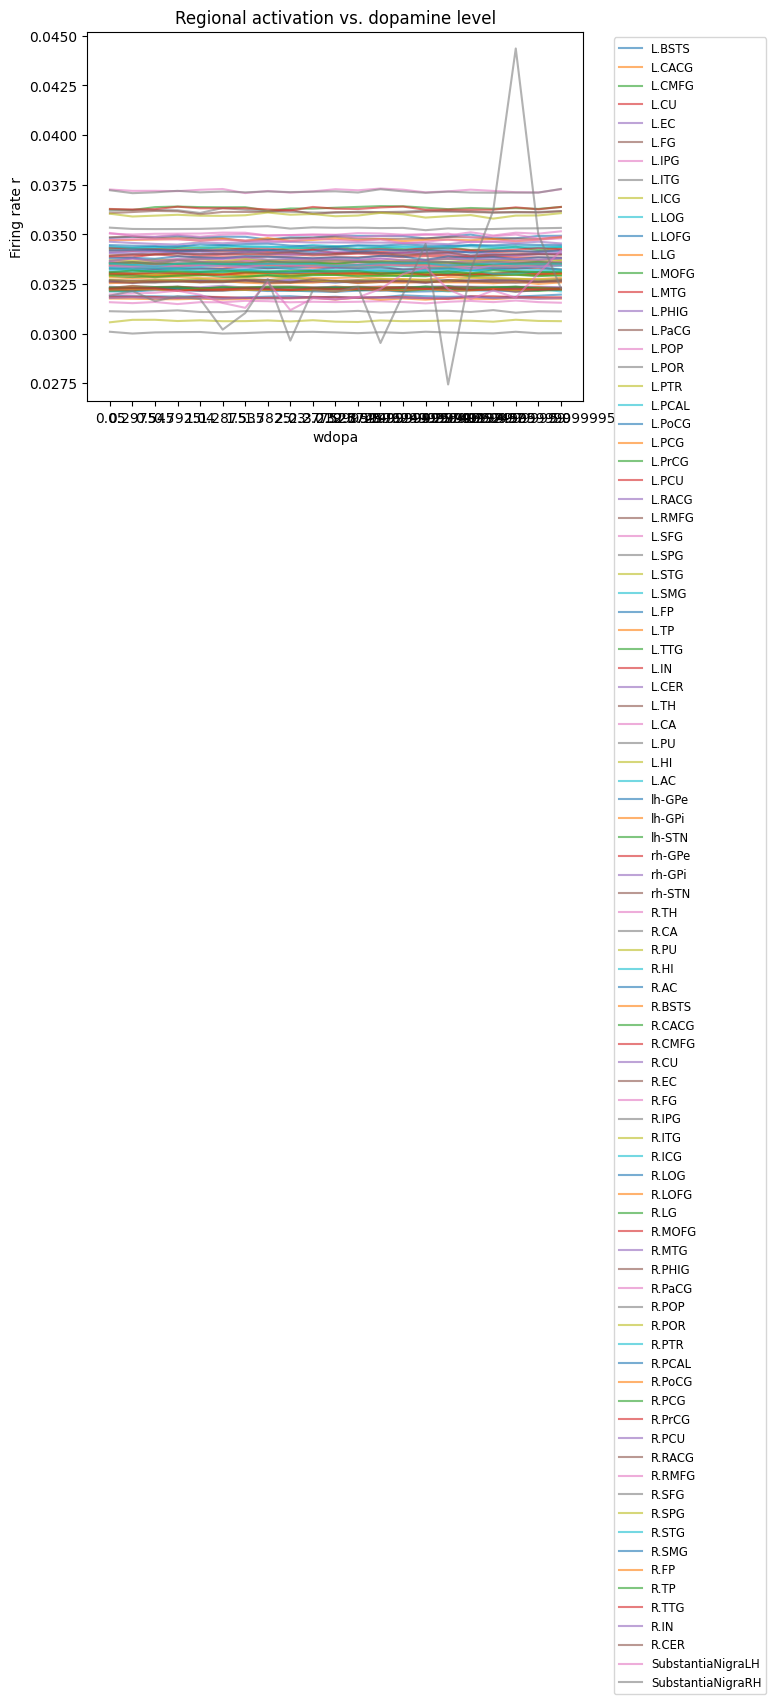

In [12]:


# Choose your wdopa values (dopamine coupling weights)
# n_nodes=conn_dopamine.shape[0]
# dt = 0.001
# t0 = 0.0
# tf = 1000.0
# c_inh=7e-2
# c_exc=7e-2
# c_dopa=7e-1
# sigma=1e-5
# r0 = np.full(n_nodes, 0.1)
# V0 = np.full(n_nodes, -70.0)
# u0 = np.full(n_nodes, 0.0)
# Sa0 = np.full(n_nodes, 0.0)
# Sg0 = np.full(n_nodes, 0.0)
# Dp0 = np.full(n_nodes, 0.05)
# y0 = np.concatenate((r0, V0, u0, Sa0, Sg0, Dp0))

import numpy as np
import pandas as pd
wdopa_values = np.linspace(0.05, 5.0, 21)
t0 = 0.0
t_max = 500.0   # ms
dt = 0.1
sigma = sigma if 'sigma' in globals() else 0.0
# Use whatever initial conditions your notebook defines (y0, params, n_nodes, regions_labels)
coupling_inhibitor, coupling_excitator = 0.07, 0.07
results = {}
times={}
for w in wdopa_values:
    coupling_weights = np.array([coupling_inhibitor, coupling_excitator, w])
    y_all, t_all = DodyModel(network, y0.copy(), t0, t_max, dt, params, coupling_weights, sigma)
    times = t_all
    final = y_all[-1]  # last state vector
    r = final[:n_nodes]  # firing rates
    results[w] = r
    print(f"Finished simulation for wdopa={w}, mean r={r.mean():.3f}, std = {r.std()}")
# Put results in a DataFrame
df = pd.DataFrame({f"{w}": results[w] for w in wdopa_values})
df.insert(0, "region", regions_labels)

# Save to CSV
df.to_csv("dody_activation_results.csv", index=False)
df_T = df.set_index("region").T

# Clean up the index so wdopa values are clear
df_T.index.name = "wdopa"
df_T.reset_index(inplace=True)

# Save to CSV
df_T.to_csv("dody.csv", index=False)
print("Saved transposed results to dody.csv")
for col in df_T.columns[1:]:
    print(col,": ",df_T[col].max() - df_T[col].min())
for col in df_T.columns[1:]:  # skip wdopa column
    plt.plot(df_T["wdopa"], df_T[col], label=col, alpha=0.6)

plt.xlabel("wdopa")
plt.ylabel("Firing rate r")
plt.title("Regional activation vs. dopamine level")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
plt.tight_layout()
plt.show()

[0.07 0.07 0.05]
Finished simulation for wdopa=0.05, mean r=0.033, std = 0.001341060735559717
[0.07   0.07   0.2975]
Finished simulation for wdopa=0.2975, mean r=0.033, std = 0.0013278483319004916
[0.07  0.07  0.545]
Finished simulation for wdopa=0.545, mean r=0.033, std = 0.0013347517239686263
[0.07   0.07   0.7925]
Finished simulation for wdopa=0.7925, mean r=0.033, std = 0.0013392800564342193
[0.07 0.07 1.04]
Finished simulation for wdopa=1.04, mean r=0.033, std = 0.0013323701583361233
[0.07   0.07   1.2875]
Finished simulation for wdopa=1.2875, mean r=0.033, std = 0.0013875325293887597
[0.07  0.07  1.535]
Finished simulation for wdopa=1.535, mean r=0.033, std = 0.001358132458167521
[0.07   0.07   1.7825]
Finished simulation for wdopa=1.7825, mean r=0.033, std = 0.001317843484681994
[0.07 0.07 2.03]
Finished simulation for wdopa=2.03, mean r=0.033, std = 0.0013906401534449025
[0.07   0.07   2.2775]
Finished simulation for wdopa=2.2775, mean r=0.033, std = 0.0013296035382235145
[0.07

/tmp/ipykernel_26560/1383561890.py:59: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


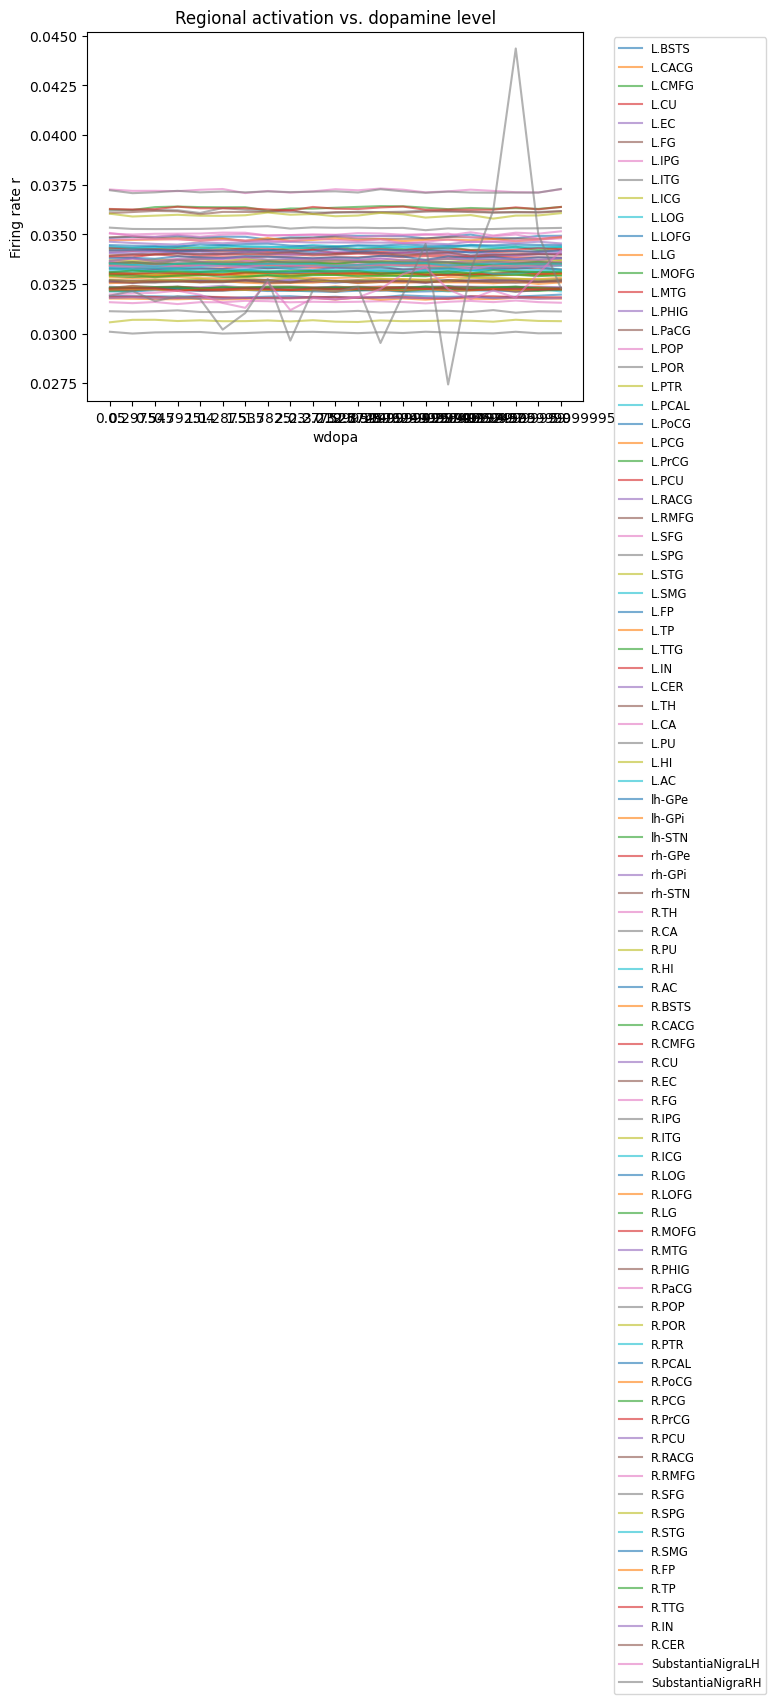

In [12]:


# Choose your wdopa values (dopamine coupling weights)
# n_nodes=conn_dopamine.shape[0]
# dt = 0.001
# t0 = 0.0
# tf = 1000.0
# c_inh=7e-2
# c_exc=7e-2
# c_dopa=7e-1
# sigma=1e-5
# r0 = np.full(n_nodes, 0.1)
# V0 = np.full(n_nodes, -70.0)
# u0 = np.full(n_nodes, 0.0)
# Sa0 = np.full(n_nodes, 0.0)
# Sg0 = np.full(n_nodes, 0.0)
# Dp0 = np.full(n_nodes, 0.05)
# y0 = np.concatenate((r0, V0, u0, Sa0, Sg0, Dp0))

import numpy as np
import pandas as pd
wdopa_values = np.linspace(0.05, 5.0, 21)
t0 = 0.0
t_max = 500.0   # ms
dt = 0.1
sigma = sigma if 'sigma' in globals() else 0.0
# Use whatever initial conditions your notebook defines (y0, params, n_nodes, regions_labels)
coupling_inhibitor, coupling_excitator = 0.07, 0.07
results = {}
times = []
for w in wdopa_values:
    coupling_weights = np.array([coupling_inhibitor, coupling_excitator, w])
    y_all, t_all = DodyModel(network, y0.copy(), t0, t_max, dt, params, coupling_weights, sigma)
    # final = y_all[-1]  # last state vector
    # r = final[:n_nodes]  # firing rates
    results[w] = y_all
    print(f"Finished simulation for wdopa={w}, mean r={r.mean():.3f}, std = {r.std()}")
# Put results in a DataFrame
df = pd.DataFrame({f"{w}": results[w] for w in wdopa_values})
df.insert(0, "time", regions_labels)

# Save to CSV
# df.to_csv("dody_activation_results.csv", index=False)
df_T = df.set_index("region").T

# Clean up the index so wdopa values are clear
df_T.index.name = "wdopa"
df_T.reset_index(inplace=True)

# Save to CSV
df_T.to_csv("dody.csv", index=False)
print("Saved transposed results to dody.csv")
for col in df_T.columns[1:]:
    print(col,": ",df_T[col].max() - df_T[col].min())
for col in df_T.columns[1:]:  # skip wdopa column
    plt.plot(df_T["wdopa"], df_T[col], label=col, alpha=0.6)

plt.xlabel("wdopa")
plt.ylabel("Firing rate r")
plt.title("Regional activation vs. dopamine level")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
plt.tight_layout()
plt.show()